# Report 2 -Titanic: Machine Learning from Disaster

* Name: Haohan Lin
* Student ID: 2015300010

## Competition Description

Complete the analysis of what kinds of people were likely to survive the sinking of the RMS Titanic. 
* Binary classification


#### Data Description:


| Variable | Definition |Key |
| --------     | --------   | -------- |
| Survived  | Survival       | 0 = No, 1 = Yes  |
| Pclass | Ticket class  | |
| Sex | Sex |    |
| Sibsp  | # of siblings / spouses aboard the Titanic |  |
| Parch | # of parents / children aboard the Titanic | |
| Ticket | Ticket number | |
| Fare  | Passenger fare  | |
| Cabin | Cabin number | |
| Embarked | Port of Embarkation |  C = Cherbourg, Q = Queenstown, S = Southampton  |


#### Libraries:

In [17]:
#machine learning
from sklearn import tree
import pydotplus
import torch

#data analysis
import pandas as pd
import string
import numpy as np
from scipy.stats import mode

#visualization
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz
import seaborn as sns
%matplotlib inline

## Acquire data

In [27]:
trainPath = 'data/train.csv'
testPath = 'data/test.csv'
trainData = pd.read_csv(trainPath)
testData = pd.read_csv(testPath)
trainData.head(6)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q


## Data analysis and feature engineering

In [3]:
trainData.describe(include = 'all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Hickman, Mr. Lewis",male,NaN,NaN,NaN,CA. 2343,NaN,C23 C25 C27,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


### Assumptions:
* PassengerId and Ticket will be dropped because they have no influence on survival.
* Age should be completed because they are vital for survival.
* New features will be created, such as Family_member, Fair_per_person and Title.
* Cabin should be dropped because most of the data are missing

### Data cleaning and feature generating

In [4]:
class dataclean():
    
    def __init__(self, df):
        
        self.df = df
        
    def extract_feature(self, data_string, feature):
        
        for subfeature in feature:
             if data_string.find(subfeature) != -1:
                return subfeature
    
    def clean(self):
        
        #Extract titles from names
        name_feature = ['Mrs.','Mr.','Miss','Master','Major','Rev',
                'Dr', 'Ms', 'Mlle','Col', 'Capt', 'Mme', 'Countess',
                'Don', 'Jonkheer']
        
        #Narrow all titles into four common titles
        def replace_titles(x):
            if x in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col','Mr.', 'Dr']:
                return 'Mr.'
            elif x in ['Countess', 'Mme','Mrs.']:
                return 'Mrs.'
            elif x in ['Mlle', 'Ms','Miss']:
                return 'Miss'
            elif x in ['Master']:
                return 'Master'
            else:
                return np.nan
                
        self.df['Title'] = self.df.Name.map(lambda x: self.extract_feature(x, name_feature))
        self.df['Title'] = self.df['Title'].map(lambda x: replace_titles(x))
        
        #Fill the two missing Embarked data with the mode of distribution
        emmod = self.df.Embarked.dropna().mode()[0]
        self.df.Embarked = self.df.Embarked.fillna(emmod)
        
        #Fill the two missing Title data with the mode of distribution
        titlemod = self.df.Title.dropna().mode()[0]
        self.df.Title = self.df.Title.fillna(titlemod)
        
        #Family size = siblings / spouses + parents / children
        self.df['Family_member'] = self.df.SibSp + self.df.Parch
        
        #Fill the missing Fare data with the median of distribution.
        self.df.Fare = self.df.Fare.fillna(self.df['Fare'].dropna().median())
        self.df['Fair_per_person'] = self.df.Fare/(self.df.Family_member + 1)

In [5]:
dataclean_train = dataclean(trainData)
dataclean_train.clean()
#Delete used/irrelevant data
trainData = trainData.drop(['Ticket', 'Cabin', 'Name', 'PassengerId', 'Parch', 'Fare'], axis=1)
#Move survival label to the last column
b = trainData.pop('Survived')
trainData['Survived'] = b

dataclean_test = dataclean(testData)
dataclean_test.clean()
testData = testData.drop(['Ticket', 'Cabin', 'Name', 'PassengerId',  'Parch', 'Fare'], axis=1)
trainData.head(10)

,Pclass,Sex,Age,SibSp,Embarked,Title,Family_member,Fair_per_person,Survived
0,3,male,22.0,1,S,Mr.,1,3.62500,0
1,1,female,38.0,1,C,Mrs.,1,35.64165,1
2,3,female,26.0,0,S,Miss,0,7.92500,1
3,1,female,35.0,1,S,Mrs.,1,26.55000,1
4,3,male,35.0,0,S,Mr.,0,8.05000,0
5,3,male,NaN,0,Q,Mr.,0,8.45830,0
6,1,male,54.0,0,S,Mr.,0,51.86250,0
7,3,male,2.0,3,S,Master,4,4.21500,0
8,3,female,27.0,0,S,Mrs.,2,3.71110,1
9,2,female,14.0,1,C,Mrs.,1,15.03540,1


### Correlating

In [6]:
#Pclass vs Survived
trainData[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean()

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [7]:
#Sex vs Survived
trainData[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean()

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [8]:
#Title vs Survived
trainData[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr.,0.163265
3,Mrs.,0.795276


In [9]:
#Embarked vs Survived
trainData[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean()

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


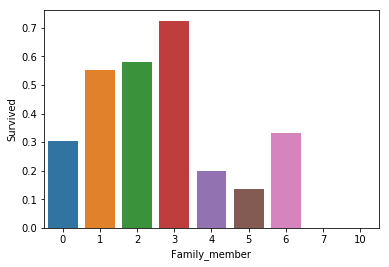

In [10]:
#Family_member vs Survived
family2survive = trainData[['Family_member', 'Survived']].groupby(['Family_member'], as_index=False).mean()
sns.barplot(x="Family_member", y="Survived", data=family2survive)

Text(0,0.5,'Survived')

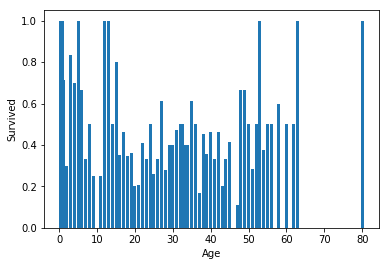

In [11]:
#Age vs Survived
age2survive = trainData[['Age', 'Survived']].groupby(['Age'], as_index=False).mean().values
plt.bar(age2survive[:,0], age2survive[:,1])
plt.xlabel('Age')
plt.ylabel('Survived')

Text(0,0.5,'age_mean')

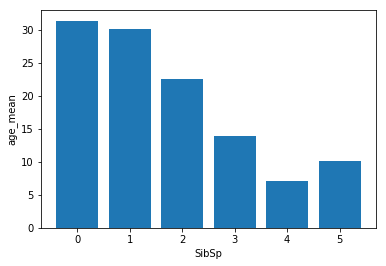

In [12]:
#Age vs SibSp
plt.figure()
age2sib = trainData[['Age', 'SibSp']].groupby(['SibSp'], as_index=False).mean().values
plt.bar(age2sib[:,0], age2sib[:,1])
plt.xlabel('SibSp')
plt.ylabel('age_mean')

#### Conclusion:
* Consider Pclass, Sex, Title, Embarked, Family_member, Deck and Age as factors for survival
* Complete missing values in Age by refering to SibSp value

### Complete age

In [13]:
def complete_age(df):
    age2sib_dict = {0:31.01485052, 1:30.04113425, 2:23.37847689, 3:17.86227941, 4:7.05555556, 5:10.2, 8:29.69911765}

    guess_age = []
    for dataset in df.values:
        if  np.isnan(dataset[2]) :
            guess_age.append(age2sib_dict[dataset[3]])
    df.Age.loc[np.isnan(df.Age)] = guess_age
    
    
complete_age(trainData)
complete_age(testData)
trainData = trainData.drop(['SibSp'], axis=1)
testData = testData.drop(['SibSp'], axis=1)

F:\Anaconda\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


### Transfer Categorical to Numerical 

In [14]:
def to_numerical(df):
    title_dict = {"Mr.": 1, "Miss": 2, "Mrs.": 3, "Master": 4}
    df['Title'] = df['Title'].map(title_dict)
    
    df['Sex'] = df['Sex'].map({"male": 1, "female": 2})
    
    df['Embarked'] = df['Embarked'].map({'S': 1, 'C': 2, 'Q': 3})

to_numerical(trainData)
to_numerical(testData)

In [15]:
trainData.head(10)

,Pclass,Sex,Age,Embarked,Title,Family_member,Fair_per_person,Survived
0,3,1,22.000000,1,1,1,3.62500,0
1,1,2,38.000000,2,3,1,35.64165,1
2,3,2,26.000000,1,2,0,7.92500,1
3,1,2,35.000000,1,3,1,26.55000,1
4,3,1,35.000000,1,1,0,8.05000,0
5,3,1,31.014851,3,1,0,8.45830,0
6,1,1,54.000000,1,1,0,51.86250,0
7,3,1,2.000000,1,4,4,4.21500,0
8,3,2,27.000000,1,3,2,3.71110,1
9,2,2,14.000000,2,3,1,15.03540,1


## Predict (Decision Tree)

In [18]:
train = torch.Tensor(trainData.values[:,:7])
label = torch.Tensor(trainData.values[:,7])
test = torch.Tensor(testData.values)

In [20]:
Tree  = tree.DecisionTreeClassifier()
Tree.fit(train, label)
test_label = Tree.predict(test)
acc_Tree = Tree.score(train, label)
acc_Tree

0.9820426487093153

In [21]:
#Generating predicition file
submitData = pd.read_csv("gender_submission.csv")
submitData['Survived'] = test_label.astype(int)
submitData.to_csv("gender_submission.csv", index=False)

### Decision Tree Visualization

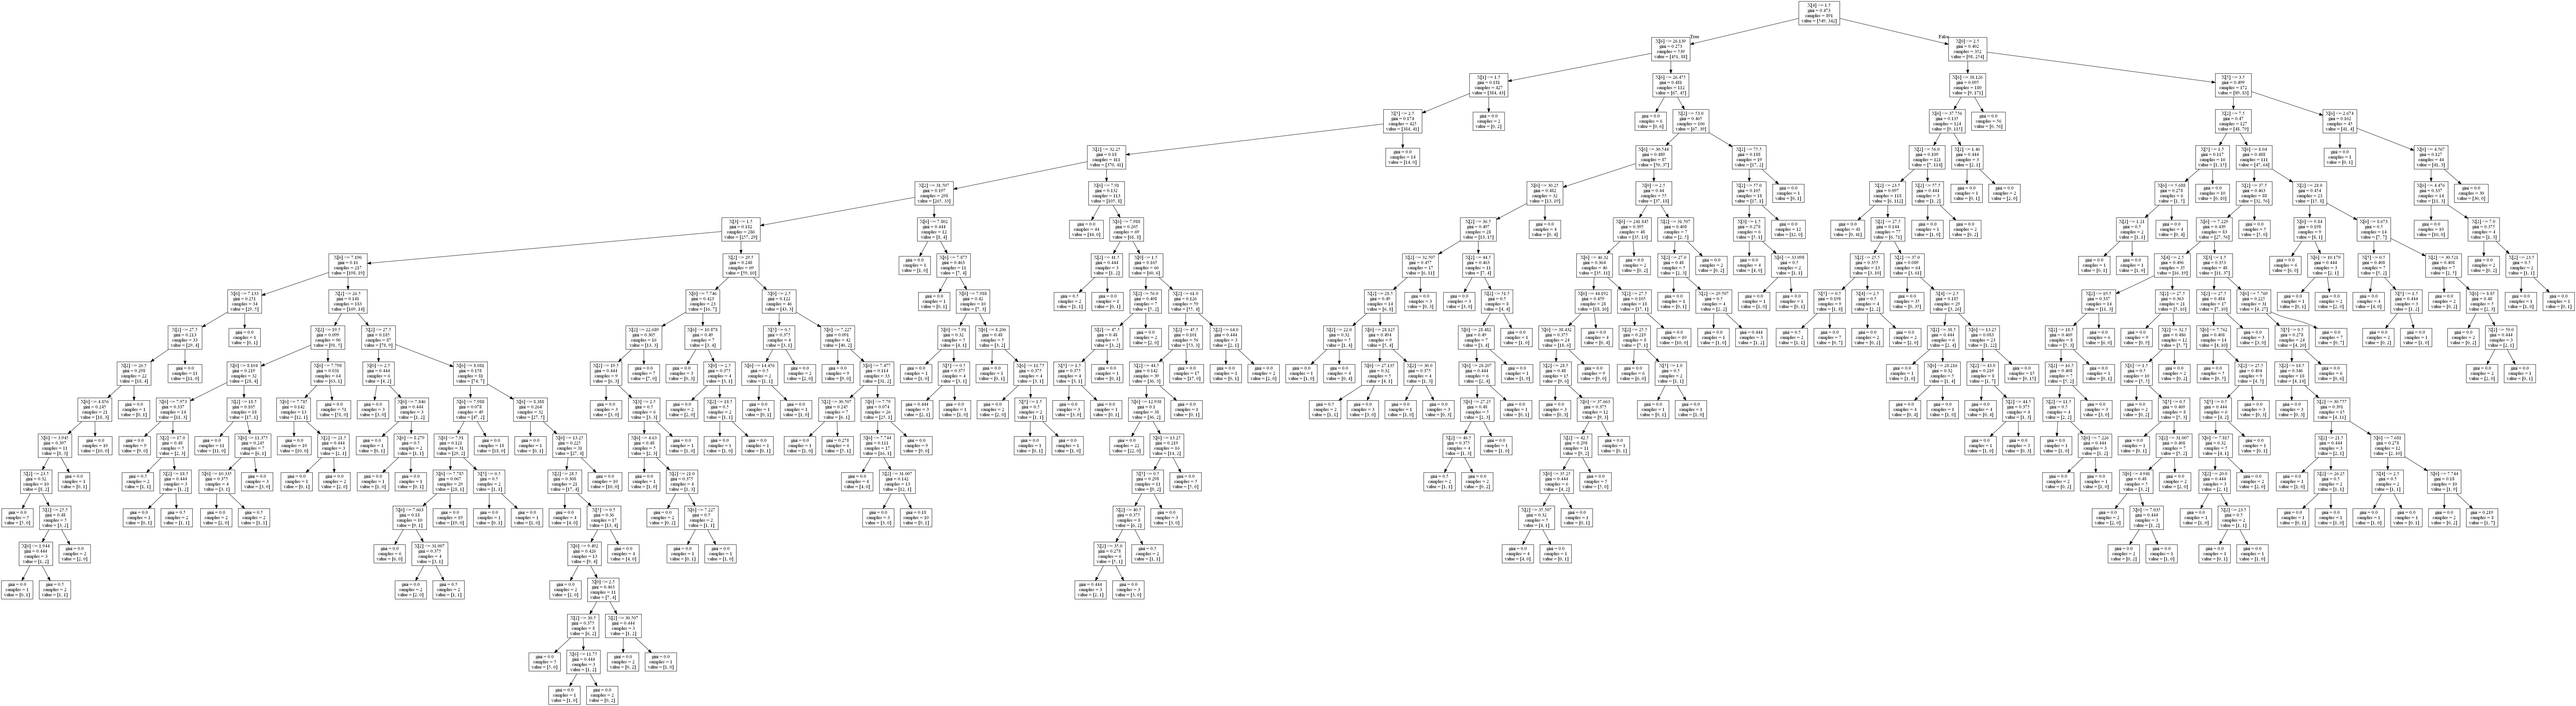

In [199]:
dot_data = tree.export_graphviz(Tree, out_file=None) 
graph = pydotplus.graph_from_dot_data(dot_data)  

Image(graph.create_png())

In [200]:
graph.write_png("tree.png")

True

## My Experiences

* It's always necessary to conduct feature engineering and data preprocessing for better training results. I used to ignore these two steps because the datasets I dealt with before were simple and friendly.
* When most of the values in a column are null, it’s better to drop the column. 
* Usually median is used with numeric columns and mode with non-numeric columns.
* It’s possible that there are no null values in the train dataset, but it’s possible that there might be null values in test dataset.
* If a parameter is closely linked to the results, it's necessary to guess all missing values based on existing data.
* Decision Tree algorithm is easy to comprehend, and by visualization we can easily conclude how decisions were made. However, if the input dataset is massive, it's better to use Neural Network.

## Reference

[1] Manav Sehgal. Titanic Data Science Solutions. https://www.kaggle.com/startupsci/titanic-data-science-solutions/notebook <br>
[2] Triangleinequality. Basic Feature Engineering with the Titanic Data. https://triangleinequality.wordpress.com/2013/09/08/basic-feature-engineering-with-the-titanic-data/